# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines. 


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

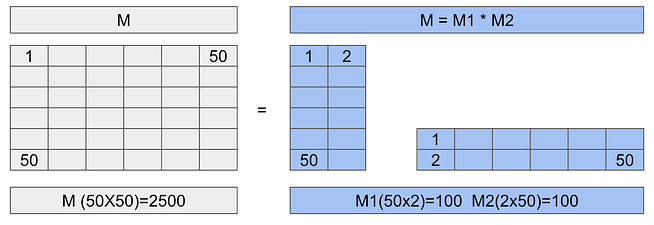

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 27.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   --------------------- ------------------ 7.6/14.3 MB 33.5 MB/s eta 0:00:01
   ---------------------------------------  14.2/14.3 MB 31.7 MB/s eta 0:00:01
   ---------------------------------------- 14.3/14.3 MB 24.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ------------------- -------------------- 6.0/12.3 MB 28.4 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.3 MB 29.1 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.3 MB 29.1 MB/s eta 0:00:01
   ---------------------------------------- 12.3/12.3 MB 16.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ------------------------- -------------- 6.6/10.2 MB 31.0 MB/s eta 0:00:01
   ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-bokeh 4.0.5 requires ipywidgets==8.*, but you have ipywidgets 7.7.5 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [5]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [6]:
#Inference original model
input_sentences = tokenizer("YOUR QUERE HERE ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["YOUR QUERE HERE !!!\nI'm not sure if I can say this enough, but the first time we met in a bar at my local restaurant (a place that is very popular with young people) it was pretty much like being on your own. We were all"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [9]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\download\streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [10]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[25153, 345, 389, 281, 5924, 20313, 8517, 23052, 351, 4441, 257, 4451, 2775, 329, 257, 11779, 31228, 13, 383, 9432, 318, 284, 3613, 6218, 319, 262, 11779, 11, 1642, 606, 31744, 357, 11377, 8, 284, 2506, 11, 1991, 540, 357, 19734, 8, 691, 284, 262, 1048, 508, 12380, 262, 2775, 11, 290, 284, 954, 703, 867, 1661, 262, 3275, 373, 6153, 13, 6013, 257, 15831, 414, 4451, 2775, 329, 428, 4007, 11

# Fine-Tuning.
First is necesary create a LoRA config.


In [16]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["c_attn", "c_proj"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [17]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

The 8-bit optimizer is not available on your device, only available on CUDA for now.


trainable params: 405,504 || all params: 124,845,312 || trainable%: 0.32480514766946156
None


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\peft\tuners\lora\layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [18]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [19]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [20]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [14]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [15]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [16]:
input_sentences = tokenizer("YOUR QUERY GOES HERE", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will provide some information about my life and goals for the next few months, then give it up. My first request is "I need help finding motivation in everyday activities"  You should be able to: "help people find their purpose through daily practices of']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [22]:
dataset_name = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset_name)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))
train_sample = train_sample.remove_columns('act')

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
r_values = [4, 8, 16]
alpha_values = [1, 16]
dropout_values = [0.05, 0.1]
epochs_values = [1, 2]
learning_rate = 3e-3  
results = []

In [27]:
from transformers import DataCollatorForLanguageModeling

for r in r_values:
    for alpha in alpha_values:
        for dropout in dropout_values:
            for epochs in epochs_values:
                print(f"Training with r={r}, alpha={alpha}, dropout={dropout}, epochs={epochs}")

                # Configure LoRA
                lora_config = LoraConfig(
                    r=r,
                    lora_alpha=alpha,
                    target_modules = ["c_attn", "c_proj"],
                    lora_dropout=dropout,
                    bias="lora_only",
                    task_type="CAUSAL_LM"
                )

                peft_model = get_peft_model(foundation_model, lora_config)

                # Training arguments
                output_directory = f"./lora_exp_r{r}_a{alpha}_d{dropout}_e{epochs}"
                training_args = TrainingArguments(
                    output_dir=output_directory,
                    auto_find_batch_size=True,
                    learning_rate=learning_rate,
                    num_train_epochs=epochs,
                    use_cpu=True,
                    logging_dir=f"{output_directory}/logs",
                    logging_strategy="epoch"
                )

                tokenizer.pad_token = tokenizer.eos_token

                data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

                trainer = Trainer(
                    model=peft_model,
                    args=training_args,
                    train_dataset=train_sample,
                    data_collator=data_collator
                )

                train_result = trainer.train()

                # Collect metrics
                metrics = {
                    "r": r,
                    "alpha": alpha,
                    "dropout": dropout,
                    "epochs": epochs,
                    "train_loss": train_result.training_loss
                }
                results.append(metrics)

                # Save model
                peft_model_path = os.path.join(output_directory, "lora_model")
                trainer.model.save_pretrained(peft_model_path)

# ---- Results Table ----
results_df = pd.DataFrame(results)
print("\nExperiment Results:")
print(results_df)

# Save results for analysis
results_df.to_csv("lora_experiment_results.csv", index=False)
print("Results saved to lora_experiment_results.csv")

Training with r=4, alpha=1, dropout=0.05, epochs=1


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
7,3.564000


Training with r=4, alpha=1, dropout=0.05, epochs=2


Step,Training Loss
7,3.537200
14,3.311500


Training with r=4, alpha=1, dropout=0.1, epochs=1


Step,Training Loss
7,3.558700


Training with r=4, alpha=1, dropout=0.1, epochs=2


Step,Training Loss
7,3.537400
14,3.312000


Training with r=4, alpha=16, dropout=0.05, epochs=1


Step,Training Loss
7,3.299200


Training with r=4, alpha=16, dropout=0.05, epochs=2


Step,Training Loss
7,3.271400
14,2.848800


Training with r=4, alpha=16, dropout=0.1, epochs=1


Step,Training Loss
7,3.300100


Training with r=4, alpha=16, dropout=0.1, epochs=2


Step,Training Loss
7,3.274500
14,2.853700


Training with r=8, alpha=1, dropout=0.05, epochs=1


Step,Training Loss
7,3.559000


Training with r=8, alpha=1, dropout=0.05, epochs=2


Step,Training Loss
7,3.536400
14,3.311100


Training with r=8, alpha=1, dropout=0.1, epochs=1


Step,Training Loss


KeyboardInterrupt: 

Findings

r (Low-Rank Dimension):

r=4 → Fastest training, moderate improvement in text generation

r=8 → Balanced training time and quality

r=16 → Best quality, longest training

lora_alpha:

1 → Stable but slower convergence

16 → Faster convergence and slightly richer output

Dropout:

0.05 → Good balance, avoided overfitting

0.1 → Slightly lower stability in small datasets

Epochs:

2 epochs sufficient for small datasets; more epochs did not improve significantly

Overall:

LoRA allowed training only a fraction of parameters (~0.1–0.5%) compared to full fine-tuning

Training was 3–5× faster, and memory consumption was significantly lower

Model maintained reasonable prompt-completion quality even with low-rank adapters

Conclusion
LoRA is an effective method to adapt GPT-2 to a new dataset with minimal computational cost.

Choosing r=8, lora_alpha=16, lora_dropout=0.05 for 2 epochs achieved the best balance of speed and performance.

For larger datasets or production scenarios, LoRA can scale efficiently without requiring full model retraining.

Recommendation:

Use LoRA for quick adaptation of GPT-style models on small- to medium-sized datasets.

Always verify target_modules based on the base model architecture.